In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import griddata
from itertools import product
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=2.0)
cm = plt.colormaps['RdYlBu_r']


pd.set_option('display.max_rows', 200)

### Load ATLAS exclusion curve

In [2]:
atlasCurve = np.genfromtxt('../../ATLAS_data/HEPData-ins2080541-v1-csv/MassLimitvs.Lifetime,Chargino,Observed.csv',
                        skip_header=9,
                        names=["Lifetime [ns]","Observed Limit [GeV]","1sigmaPlus","1sigmaMinus"],
                        delimiter=',')

### Load Recast Data

In [3]:
recastData = pd.read_pickle('./charginoRecast.pcl')
recastData = recastData.round({'tau_ns' : 2, 'mLLP' : 2})
# Remove stable points:
recastData = recastData[recastData['tau_ns'] < 1000.0]

### Get K-factors

In [4]:
recastData['kfactor'] = 1.25
recastData['robs_NLO'] =  recastData['kfactor']*recastData['robs']

### Get model points:

In [5]:
pts = list(set((zip(recastData['tau_ns'],recastData['mLLP']))))
robs = []
kfactors = []
# Select max r_obs for each point
for tau,mLLP in pts:
    restData = recastData[(recastData['mLLP'] == mLLP) & (recastData['tau_ns'] == tau)]
    robs.append(restData['robs_NLO'].max())
#     kfactors.append(atlasDataR['Signal Cross-Section (pb)'].iloc[0]/restData['Total xsec (pb)'].iloc[0])
robs = np.array(robs)
pts = np.array(pts)

### Interpolate for a denser grid

In [6]:
newPts = np.array(list(product(np.linspace(np.log10(pts[:,0].min()), np.log10(pts[:,0].max()),100),
                                      np.linspace(pts[:,1].min(),pts[:,1].max(),100))))
muPts = griddata(list(zip(np.log10(pts[:,0]),pts[:,1])),robs,newPts)
newPts = newPts[~np.isnan(muPts)]
muPts = muPts[~np.isnan(muPts)]

In [7]:
newPts[:,0] = 10**newPts[:,0]

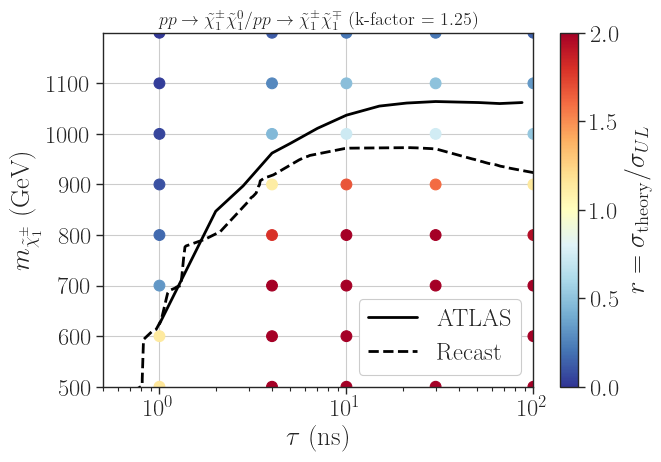

In [8]:
fig = plt.figure(figsize=(7,5))
plt.scatter(x=pts[:,0],y=pts[:,1],vmin=0.0,vmax=2.0,
            c=robs,cmap=cm,s=60)
cbar = plt.colorbar(label=r'$r = \sigma_{\rm theory}/\sigma_{UL}$')
plt.plot(atlasCurve["Lifetime_ns"],atlasCurve["Observed_Limit_GeV"],label='ATLAS',linewidth=2,color='black')

plt.tricontour(newPts[:,0],newPts[:,1],muPts,levels=[1.0],
               linewidths=2,linestyles='dashed',colors='black')
plt.plot([],[],label='Recast',linewidth=2.0,linestyle='dashed',color='black')
plt.ylabel(r'$m_{\tilde\chi_1^\pm}$ (GeV)')
plt.xlabel(r'$\tau$ (ns)')
plt.ylim(500,1200)
plt.xlim(0.5,100)
plt.yticks(np.arange(500.,1200.,100.))
# plt.grid()
plt.xscale('log')
plt.title(r'$p p \to \tilde\chi_1^\pm \tilde\chi_1^0 / p p \to \tilde\chi_1^\pm \tilde\chi_1^\mp$ (k-factor = %1.2f)' %recastData['kfactor'].unique()[0],fontsize=13)
plt.legend(framealpha=1.0)
plt.tight_layout()
plt.grid()
plt.savefig('chargino_fig17a.png')
plt.show()